# Simple Image Classifier

Beginner-friendly image classifier built with PyTorch and CIFAR-10.

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="https://upload.wikimedia.org/wikipedia/commons/a/ae/DenseCap_%28Johnson_et_al.%2C_2016%29_%28cropped%29.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


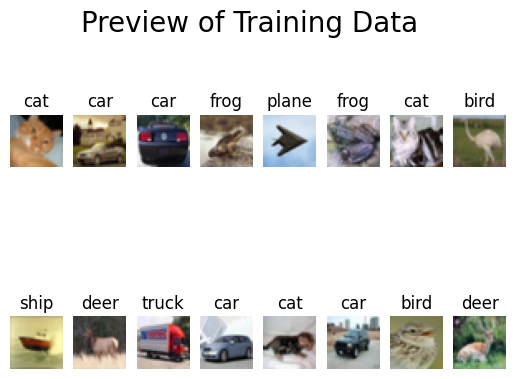

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #init Conv2d
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

        # Initialize linear weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc1.bias, 0.1)
        nn.init.constant_(self.fc2.bias, 0.1)
        nn.init.constant_(self.fc3.bias, 0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.001)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.001)
        # x = F.softmax(self.fc3(x), dim=1)
        x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
# Define the learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.4)  # gamma controls the decay rate

# Load previously trained model
PATH = './cifar_net2.pth'
#net.load_state_dict(torch.load(PATH))

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [19]:
from tqdm import tqdm

EPOCHS = 8
net.train()
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 
                                  desc=f"Epoch {epoch + 1} of {EPOCHS} / lr={scheduler.get_last_lr()[0]:.1e}",
                                  leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

# Save our trained model
torch.save(net.state_dict(), PATH)
print(" ... finished")

Training...


Epoch 8 of 8 / lr=3.4e-07: 100%|███████████| 3125/3125 [00:13<00:00, 231.62it/s]

 ... finished


# Step 4: Test the trained model

Let's test our model!

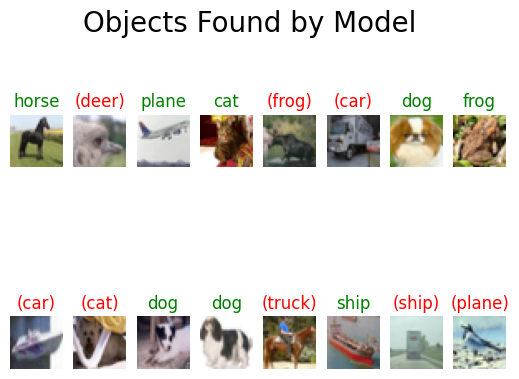

In [20]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [21]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.4 %
Accuracy for class: car   is 59.4 %
Accuracy for class: bird  is 33.6 %
Accuracy for class: cat   is 27.7 %
Accuracy for class: deer  is 37.9 %
Accuracy for class: dog   is 49.2 %
Accuracy for class: frog  is 58.9 %
Accuracy for class: horse is 56.2 %
Accuracy for class: ship  is 54.8 %
Accuracy for class: truck is 58.1 %


## Step 6 - Inspect model


In [18]:
weights = net.fc3.weight
print(weights)


Parameter containing:
tensor([[-1.0224e-01,  1.2598e-01,  2.3276e-01,  2.9480e-02,  3.9909e-01,
          2.1907e-03, -2.3129e-01, -3.8204e-02, -4.0688e-01,  2.1341e-01,
          7.1502e-02, -3.4749e-01, -3.3181e-02, -5.6761e-02,  2.7077e-01,
          2.5107e-01,  5.7673e-02,  3.7881e-01,  8.1567e-02, -4.5094e-02,
          2.3073e-01,  2.0759e-02,  9.0580e-03,  1.0460e-01, -1.2608e-01,
         -6.2400e-02,  1.4133e-01,  2.2311e-02,  1.4647e-01, -7.7761e-02,
         -4.1998e-02,  1.3893e-03, -1.0771e-01,  4.4728e-02,  5.2941e-02,
          3.4634e-01, -1.8921e-01,  4.7860e-02, -4.2539e-03,  4.9817e-02,
         -2.3951e-02,  1.3407e-01, -4.4092e-02, -2.8276e-01,  5.8085e-02,
          1.1094e-01, -1.0982e-01,  4.6732e-02,  2.5866e-01,  1.8869e-01,
          4.2145e-01, -1.9834e-01, -9.0650e-05, -1.8609e-02, -1.3496e-01,
         -1.9030e-01,  4.0578e-01,  5.6283e-02,  2.9455e-01,  1.2174e-01,
         -5.0960e-02, -6.8222e-02,  3.3263e-02,  7.4460e-02,  4.6186e-01,
         -2.0180